## Servo Data Set

Dataset available at https://archive.ics.uci.edu/ml/datasets/Servo

#### Data Set Information:

    The data was from a simulation of a servo system involving a servo amplifier, a motor, a lead screw/nut, and a sliding carriage of some sort. The output value is rise time, or the time required for the system to respond to a step change in a position set point.

    This data covers an extremely non-linear phenomenon - predicting the rise time of a servomechanism in terms of two (continuous) gain settings and two (discrete) choices of mechanical linkages.


#### Attribute Information:

    1. motor: A,B,C,D,E
    2. screw: A,B,C,D,E
    3. pgain: 3,4,5,6
    4. vgain: 1,2,3,4,5
    5. class: 0.13 to 7.10


### Regression Task

    This notebook demonstrates how a machine learning model can determine the rise time of a servo motor based on the mechanical parameters and the gain values of a controller. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

seed = 92
np.random.seed(seed)
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
col_names = ['motor', 'screw', 'pgain', 'vgain', 'rise_time']

df = pd.read_csv('data/servo.data', header = None, names=col_names)

In [3]:
df.head()

,motor,screw,pgain,vgain,rise_time
0,E,E,5,4,0.281251
1,B,D,6,5,0.506252
2,D,D,4,3,0.356251
3,B,A,3,2,5.500033
4,D,B,6,5,0.356251


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 5 columns):
motor        167 non-null object
screw        167 non-null object
pgain        167 non-null int64
vgain        167 non-null int64
rise_time    167 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 6.6+ KB


#### EDA

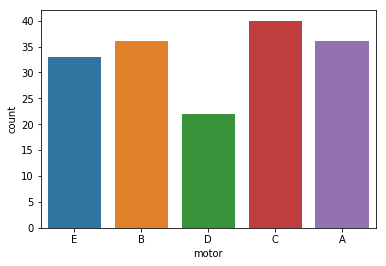

In [5]:
sns.countplot(df.motor, data = df)

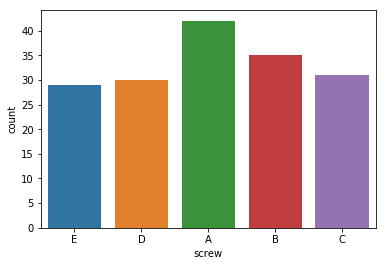

In [6]:
sns.countplot(df.screw, data = df)

In [7]:
df.groupby('motor').describe().T

motor                    A          B          C          D          E
pgain     count  36.000000  36.000000  40.000000  22.000000  33.000000
          mean    4.166667   4.166667   4.325000   3.818182   4.151515
          std     1.000000   1.000000   1.071484   0.957992   1.034445
          min     3.000000   3.000000   3.000000   3.000000   3.000000
          25%     3.000000   3.000000   3.750000   3.000000   3.000000
          50%     4.000000   4.000000   4.000000   4.000000   4.000000
          75%     5.000000   5.000000   5.000000   4.000000   5.000000
          max     6.000000   6.000000   6.000000   6.000000   6.000000
vgain     count  36.000000  36.000000  40.000000  22.000000  33.000000
          mean    2.583333   2.583333   2.475000   2.318182   2.666667
          std     1.401530   1.401530   1.377242   1.286796   1.406829
          min     1.000000   1.000000   1.000000   1.000000   1.000000
          25%     1.000000   1.000000   1.000000   1.000000   2.000000
          50%     2.000000   2.000000   2.000000   2.000000   2.000000
          75%     4.000000   4.000000   3.250000   3.000000   4.000000
          max     5.000000   5.000000   5.000000   5.000000   5.000000
rise_time count  36.000000  36.000000  40.000000  22.000000  33.000000
          mean    1.761111   1.681942   1.254061   0.917613   1.144893
          std     1.822645   1.760003   1.387926   0.675960   1.568450
          min     0.243751   0.206250   0.206250   0.281251   0.131250
          25%     0.506252   0.496877   0.506252   0.431252   0.431252
          50%     0.806255   0.806255   0.543753   0.696877   0.806255
          75%     3.899964   3.749966   1.126563   1.232811   1.100000
          max     5.700042   5.500033   5.100014   2.699979   7.100108

In [8]:
df.groupby('screw').describe().T

screw                    A          B          C          D          E
pgain     count  42.000000  35.000000  31.000000  30.000000  29.000000
          mean    4.357143   4.142857   4.064516   4.066667   4.068966
          std     1.055102   1.004193   0.997847   1.014833   1.032716
          min     3.000000   3.000000   3.000000   3.000000   3.000000
          25%     4.000000   3.000000   3.000000   3.000000   3.000000
          50%     4.000000   4.000000   4.000000   4.000000   4.000000
          75%     5.000000   5.000000   4.500000   4.750000   5.000000
          max     6.000000   6.000000   6.000000   6.000000   6.000000
vgain     count  42.000000  35.000000  31.000000  30.000000  29.000000
          mean    2.500000   2.571429   2.516129   2.566667   2.551724
          std     1.347989   1.420143   1.387347   1.381736   1.403725
          min     1.000000   1.000000   1.000000   1.000000   1.000000
          25%     1.000000   1.000000   1.000000   1.250000   1.000000
          50%     2.000000   2.000000   2.000000   2.000000   2.000000
          75%     3.000000   4.000000   3.500000   3.750000   4.000000
          max     5.000000   5.000000   5.000000   5.000000   5.000000
rise_time count  42.000000  35.000000  31.000000  30.000000  29.000000
          mean    1.768461   1.391963   1.248586   1.161247   1.225643
          std     1.982259   1.440169   1.402858   1.289518   1.413128
          min     0.281251   0.356251   0.131250   0.206250   0.206250
          25%     0.665629   0.543753   0.431252   0.403127   0.468752
          50%     0.806255   0.693754   0.543753   0.506252   0.506252
          75%     1.190617   1.399996   1.199999   1.251560   1.106248
          max     7.100108   4.699995   4.699995   4.699995   4.699995

In [9]:
df.groupby('motor').mean()

,pgain,vgain,rise_time
motor,,,
A,4.166667,2.583333,1.761111
B,4.166667,2.583333,1.681942
C,4.325000,2.475000,1.254061
D,3.818182,2.318182,0.917613
E,4.151515,2.666667,1.144893


In [10]:
df.groupby('screw').mean()

,pgain,vgain,rise_time
screw,,,
A,4.357143,2.500000,1.768461
B,4.142857,2.571429,1.391963
C,4.064516,2.516129,1.248586
D,4.066667,2.566667,1.161247
E,4.068966,2.551724,1.225643


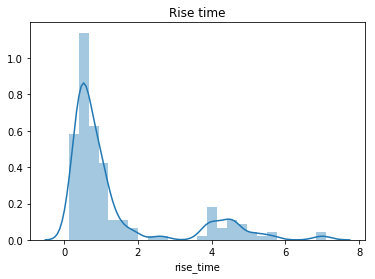

In [11]:
sns.distplot(df.rise_time)
plt.title('Rise time')
plt.show()

In [22]:
df.columns

Index(['motor', 'screw', 'pgain', 'vgain', 'rise_time'], dtype='object')

#### Data Preprocessing

Encoding the categorical variables.

In [24]:
le = LabelEncoder()

df['motor'] = le.fit_transform(df.motor)
df['screw'] = le.fit_transform(df.screw)

Selecting input features and target variable.

In [25]:
X = df.drop('rise_time', axis = 1)
y = df[['rise_time']]

Splitting the dataset into train and test sets.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = seed)

Defining various models to perform cross validation to determine which model performs better.

In [26]:
models = []

models.append(('LR', LinearRegression()))
models.append(('LassoR', Lasso()))
models.append(('RidgeR', Ridge()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('RFR', RandomForestRegressor()))


In [27]:
results = []
names = []
scoring = ['neg_mean_squared_error', 'r2']
for name, model in models:
    kfold = KFold(n_splits=5, random_state=seed)
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: ,MSE :%f ,R2 :%f" % (name, cv_results['test_neg_mean_squared_error'].mean(), cv_results['test_r2'].mean())
    print(msg)

LR: ,MSE :-1.521286 ,R2 :0.349705
LassoR: ,MSE :-2.729053 ,R2 :-0.059700
RidgeR: ,MSE :-1.518145 ,R2 :0.353480
DTR: ,MSE :-0.311044 ,R2 :0.857711
RFR: ,MSE :-0.511776 ,R2 :0.807060


Decision Tree Regressor and Random Forest Regressor have low MSE and high R2 Score. So, they are selected and tuned for improving the performance.

#### Decision Tree Regressor

In [18]:
dtc = DecisionTreeRegressor(max_depth=5, min_samples_leaf=2, random_state=seed)

dtc.fit(X_train, y_train)

y_pred_on_train = dtc.predict(X_train)
y_pred = dtc.predict(X_test)

print('Mean Absolute Error -', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error -', mean_squared_error(y_test, y_pred))
print('R2 Score - ', r2_score(y_test, y_pred))

Mean Absolute Error - 0.12771015043604111
Mean Squared Error - 0.03725337956769946
R2 Score -  0.976097858891528


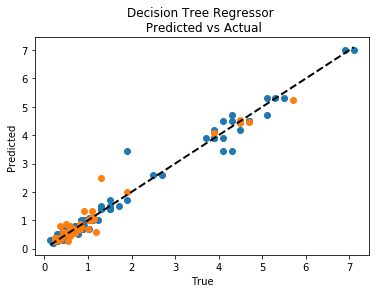

In [28]:
plt.scatter(y_train, y_pred_on_train, label = 'Training Data')
plt.scatter(y_test, y_pred, label = 'Testing Data')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.title('Decision Tree Regressor \n Predicted vs Actual')
plt.show()

#### Random Forest Regressor

In [20]:
dtc = RandomForestRegressor(n_estimators=300, max_depth=5, random_state=seed)

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

print('Mean Absolute Error -', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error -', mean_squared_error(y_test, y_pred))
print('R2 Score - ', r2_score(y_test, y_pred))

Mean Absolute Error - 0.14211612258106932
Mean Squared Error - 0.05988929177784223
R2 Score -  0.9615744311100943


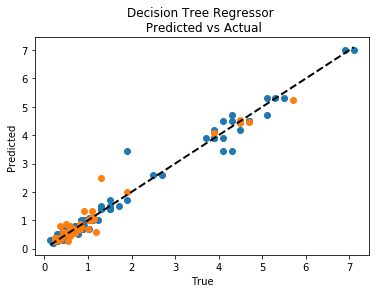

In [21]:
plt.scatter(y_train, y_pred_on_train, label = 'Training Data')
plt.scatter(y_test, y_pred, label = 'Testing Data')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.title('Decision Tree Regressor \n Predicted vs Actual')
plt.show()

#### Both Decision Tree Regressor and Random Forest Classifier reach an R2 Score of 0.96. (A good R2 score should be as close as to 1.0) 